# Aufbereitung der AquiTronic-Datenlogger-Rohdaten zur  Darstellung von Grundwasserganglinien

**Im Vorfeld:** AquiTronic-Software öffnen, jeweilige Messstelle auswählen, Datensatz als xlsx-Datei exportieren und verständlich umbenennen. Zusammen mit den Dateien von allen anderen Messstellen in einem gemeinsamen Ordner ablegen. 

Das folgende Skript soll die redundante Berechnung von Sensortiefe (in m NHN), Wasserstand des jeweiligen Datenpunkts (m NHN) sowie Flurabstand (m u. GOK) von Wasserstandsaufzeichnungen eines AquiTronic-Datenloggers automatisieren. Es basiert auf der Datenstruktur der in AquiTronic exportierten xlsx-Dateien einer Messstelle.
Aufgrund unterschiedlicher ROK, GOK und Abstich-Werte für jede Messstelle wurde nicht mit einer Schleife gearbeitet, es müssen jedoch lediglich der Dateiname und die genannten Variablen geändert werden, was mit einer erheblichen Zeitersparnis verbunden ist. 

Zuerst werden die notwendigen Bibliotheken eingeladen.

In [1]:
import os 
from openpyxl import load_workbook

Im Folgenden wird der Pfad zum Ordner angegeben, in dem sich die Rohdaten befinden.

In [2]:
data_path = r"..." 

Nun der Dateiname: Dieser Name wird für jede Datei neu geändert. 

In [3]:
filename = "MWMS2 12475_roh.xlsx"

Die Daten sollten im Sheet "Daten" folgendermaßen aufgebaut sein: Spalte 1 "Datum", Spalte 2 "Pegel ueber Sensor [m]", Spalte 3 "Temperatur [°C]". Jetzt wird der output-Path angegeben, wo die Daten hingespeichert werden sollen. 

In [4]:
output_path = r"..."

Wir laden jetzt die jeweilige Datei und wählen das Sheet mit Namen "Daten" aus.

In [5]:
input_file = os.path.join(data_path, filename)
wb = load_workbook(input_file)
ws = wb["Daten"]

Als letzte anzupassende Variablen hier bitte die korrekte **ROK, GOK sowie den Abstich** der jeweiligen Messstelle angeben.

In [6]:
rok = 39.62
gok = 38.53 
abstich = 2.58

In [14]:
ws["K3"] = rok      
ws["K4"] = gok       
ws["K5"] = abstich 

Die jeweiligen Zellen im Sheet werden beschriftet.

In [15]:
ws["J3"] = "ROK  [m NHN]"
ws["J4"] = "GOK  [m NHN]"
ws["J5"] = "Abstich [m]"
ws["J8"] = "Sensortiefe [m NHN]"

ws["D1"] = "Wasserstand [m NHN]"
ws["E1"] = "Flurabstand [m u. GOK]"

Jetzt wird die Sensortiefe aus ROK-Abstich-Pegel ü. Sensor am Tag des Abstichs berechnet. **VORSICHT:** Hierbei wird immer der letzte Eintrag der Pegel ü. Sensor-Spalte genommen (da dieser für gewöhnlich vom Tag des Abstichs/der Geländearbeit stammt). Falls dies nicht der Fall ist (z.B. alter Abstich, weil der Ort nicht zugänglich war), so muss die Zeile Code mit ws["K8"] geändert werden (siehe Kommentar unten).

In [16]:
last_row = ws.max_row
while ws[f"B{last_row}"].value is None:
    last_row -= 1
ws["K8"] = f"=K3-K5-B{last_row}" 
# Dies ggfs. anpassen, z.B. in ws["K8"] = f"=K3-K5-B2000", wenn sich der zum Abstich passende Pegel ü. Sensor-Eintrag in Zeile 2000 befindet.

Wir berechnen den Wasserstand in m NHN, indem Sensortiefe und Pegel ü. Sensor-Wert jeder Zeile addiert werden. Danach wird der Flurabstand als Differenz von GOK und Wasserstand berechnet.

In [17]:
for row in range(4, last_row + 1):
    ws[f"D{row}"] = f"=$K$8+B{row}"

for row in range(4, last_row + 1):
    ws[f"E{row}"] = f"=$K$4-D{row}"

Als letzten Schritt exportieren wir die neue xlsx-Datei in den oben definierten output-Path.

In [23]:
base, ext = os.path.splitext(filename)
output_file = os.path.join(output_path, f"{base}_bearbeitet{ext}")

wb.save(output_file)

# print(f"Bearbeitete Excel-Datei wurde erfolgreich unter {output_path} gespeichert.")

Der nächste Schritt ist das Erstellen von Grund- oder Moorwasserganglinien als Plot. Hierfür sei auf das bereits existierende R-Skript verwiesen: 

https://github.com/dkc00/Geodata/blob/main/skripte/R/grundwasserganglinien.R

Alternativ können die Ganglinien auch bereits direkt in Python geplottet werden (abhängig davon, ob ein einheitliches Design notwendig sein soll). Siehe dafür den unten folgenden Code.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import numpy as np

In [8]:
files = {
    "MWMS2 12475.xlsx": "MWMS2",
    "MWMS7 12478.xlsx": "MWMS7",
    "MWMS9 12470.xlsx": "MWMS9",
    "MWMS10 12474.xlsx": "MWMS10",
    "MWMS13 12472.xlsx": "MWMS13",
    "MWMS15 12473.xlsx": "MWMS15",
    "MWMS16 12471.xlsx": "MWMS16"
}

path = r"...\Datenlogger Göldenitz Dez25"   # pfad des ordners             
path_niederschlag = r"...\Niederschlag_Goeldenitz.xlsx" # pfad der niederschlags-datei

In [22]:
# Entweder Farben automatisch als Regenbogen generieren 

# colors = plt.cm.rainbow(np.linspace(0, 1, len(files)))

# oder manuell Farben auswählen (wenn sich die automatischen zu ähnlich sind) 

farben = [
    "red", "blue", "darkorange", "yellow",
    "darkgreen", "purple",  "brown", "black"
]

colors = farben[:len(files)]

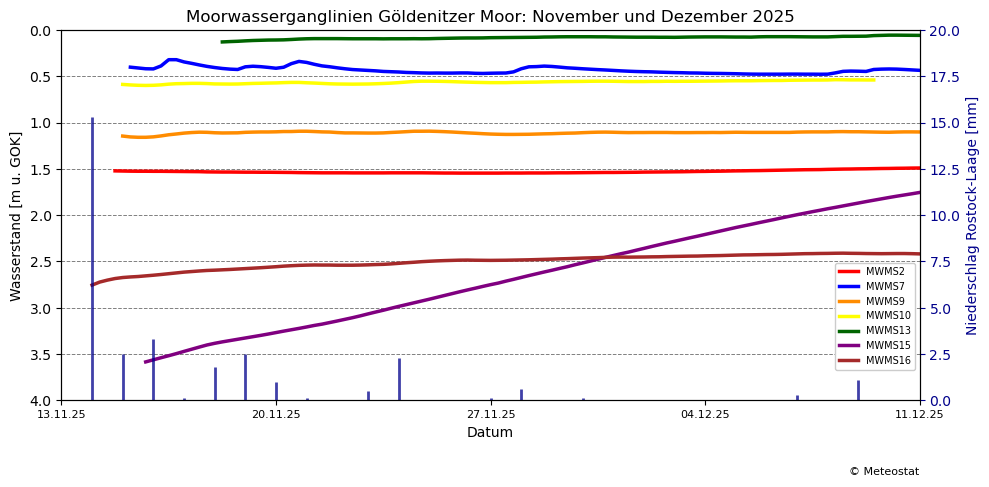

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

start = pd.to_datetime("2025-11-13")
end   = pd.to_datetime("2025-12-11")

ax.set_xlim(start, end)
ax.set_ylim(4, 0)  # Hier die tiefsten Flurabstände anpassen! (zb 3 bis 0 m u. GOK)

ax.set_xlabel("Datum")
ax.set_ylabel("Wasserstand [m u. GOK]")
ax.set_title("Moorwasserganglinien Göldenitzer Moor: November und Dezember 2025")

ticks = pd.date_range(start, end, freq="7D")
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%y"))
plt.setp(ax.get_xticklabels(), fontsize=8)

for y in np.arange(0, 4, 0.5): # Hier verändern, in welchen Abschnitten von wo bis wo der Hintergrund schraffiert sein soll 
    ax.axhline(y, color="gray", linestyle="dashed", linewidth=0.7)


for (file, label), color in zip(files.items(), colors):
    df = pd.read_excel(
        os.path.join(path, file),
        sheet_name=1,   
        skiprows=3
    )

    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format="%d.%m.%y %H:%M:%S")

    ax.plot(
        df.iloc[:, 0],
        df.iloc[:, 4],   
        label=label,
        color=color,
        linewidth=2.5
    )

ax.legend(
    loc="lower right",
    bbox_to_anchor=(1.0, 0.07),
    fontsize=7,
    frameon=True,
    framealpha=1,
    facecolor="white"
)


ax2 = ax.twinx()

niederschlag = pd.read_excel(path_niederschlag, skiprows=1)
niederschlag.iloc[:, 0] = pd.to_datetime(
    niederschlag.iloc[:, 0],
    format="%d.%m.%Y"
)

ax2.vlines(
    x=niederschlag.iloc[:, 0],
    ymin=0,
    ymax=niederschlag.iloc[:, 1],
    color="darkblue",
    alpha=0.75,
    linewidth=2
)

ax2.set_ylim(0, 20)
ax2.set_ylabel("Niederschlag Rostock-Laage [mm]", color="darkblue")
ax2.tick_params(axis="y", colors="darkblue")

ax.text(
    1.0, -0.18,
    "© Meteostat",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=8
)

plt.tight_layout()
plt.show()

In [26]:
output_path = Path("...") / "ganglinien_plot.png" # Hier Outputpath einfügen! Wo soll das Bild hingespeichert werden? 
fig.savefig(output_path, dpi=300, bbox_inches="tight")


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Koch\AppData\Local\Temp\ipykernel_12392\3332627415.py:1: SyntaxWarning: invalid escape sequence '\D'
  output_path = Path("M:\DBU Göldenitzer Moor\Feldarbeit\Feldarbeit Dezember 25") / "ganglinien_plot.png"
